# Apply Multinomial NB on these feature sets

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import re

import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

## 1. Reading Data

In [2]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [4]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


## 1.2 Preprocessing : project_subject_categories

In [5]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

project_data.drop(['project_subject_categories'], axis=1, inplace=True) # Dropping cat column

project_data['clean_categories'] = cat_list
project_data['clean_categories'] = project_data['clean_categories'].str.lower()

## 1.2.1 Preprocessing : project_subject_subcategories

In [6]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())
        
project_data.drop(['project_subject_subcategories'], axis = 1, inplace = True)

project_data['clean_subcategories'] = sub_cat_list
project_data['clean_subcategories'] = project_data['clean_subcategories'].str.lower()

## 1.2.2 Preprocessing : essay

In [7]:
# https://stackoverflow.com/a/47091490/4084039

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [8]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'

stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [9]:
from tqdm import tqdm

def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [10]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

project_data["preprocessed_essays"] = preprocess_text(project_data['essay'].values)

100%|█████████████████████████████████████████████████████████████████████████| 109248/109248 [02:00<00:00, 903.93it/s]


## 1.2.3 Preprocessing : project_title

In [11]:
project_data["preprocessed_titles"] = preprocess_text(project_data['project_title'].values)

100%|███████████████████████████████████████████████████████████████████████| 109248/109248 [00:05<00:00, 21443.15it/s]


## 1.2.4 Preprocessing : project_grade_category

In [12]:
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.lower()
project_data['project_grade_category'].value_counts()

grades_prek_2    44225
grades_3_5       37137
grades_6_8       16923
grades_9_12      10963
Name: project_grade_category, dtype: int64

## 1.2.5 Preprocessing : school_state

In [13]:
project_data['school_state'] = project_data['school_state'].str.lower()

## 1.2.6 Preprocessing : teacher_prefix

In [14]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].fillna('Mrs.')

In [15]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace('.','')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.lower()

## 1.2.7 Preprocessing : price

In [16]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()

# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on = 'id', how = 'left')

In [17]:
# Dropping unnecessary columns

project_data.drop(['project_submitted_datetime'], axis=1, inplace=True)
project_data.drop(['project_title'], axis=1, inplace=True)
project_data.drop(['project_essay_1'], axis=1, inplace=True)
project_data.drop(['project_essay_2'], axis=1, inplace=True)
project_data.drop(['project_essay_3'], axis=1, inplace=True)
project_data.drop(['project_essay_4'], axis=1, inplace=True)
project_data.drop(['project_resource_summary'], axis=1, inplace=True)
project_data.drop(['Unnamed: 0'], axis=1, inplace=True)
project_data.drop(['id'], axis=1, inplace=True)
project_data.drop(['teacher_id'], axis=1, inplace=True)
project_data.drop(['quantity'], axis=1, inplace=True)
project_data.drop(['essay'], axis=1, inplace=True)

In [18]:
project_data.head()

,teacher_prefix,school_state,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,preprocessed_essays,preprocessed_titles,price
0,mrs,in,grades_prek_2,0,0,literacy_language,esl literacy,students english learners working english seco...,educational support english learners home,154.60
1,mr,fl,grades_6_8,7,1,history_civics health_sports,civics_government teamsports,students arrive school eager learn polite gene...,wanted projector hungry learners,299.00
2,ms,az,grades_6_8,1,0,health_sports,health_wellness teamsports,true champions not always ones win guts mia ha...,soccer equipment awesome middle school students,516.85
3,mrs,ky,grades_prek_2,4,1,literacy_language math_science,literacy mathematics,work unique school filled esl english second l...,techie kindergarteners,232.90
4,mrs,tx,grades_prek_2,1,1,math_science,mathematics,second grade classroom next year made around 2...,interactive math tools,67.98


# 1.3 Vectorizing

<h2>1.3.1 Splitting data into Train and Test</h2>

In [19]:
y = project_data['project_is_approved'].values
X = project_data.drop(['project_is_approved'], axis=1)

X.shape

(109248, 9)

In [20]:
# Splitiing data into train, cv, and test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, stratify = y)

## 1.3.2 Bag of words

<h2>Make Data Model Ready: encoding eassay, and project_title</h2>

In [21]:
vectorizer_title_bow = CountVectorizer(min_df = 10)
vectorizer_title_bow.fit(X_train['preprocessed_titles'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_bow = vectorizer_title_bow.transform(X_train['preprocessed_titles'].values)
X_test_title_bow = vectorizer_title_bow.transform(X_test['preprocessed_titles'].values)

print("After vectorizations")
print("Shape of matrix after applying BOW :", X_train_title_bow.shape)

After vectorizations
Shape of matrix after applying BOW : (73196, 2518)


In [22]:
vectorizer_essay_bow = CountVectorizer(min_df = 10)
vectorizer_essay_bow.fit(X_train['preprocessed_essays'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer_essay_bow.transform(X_train['preprocessed_essays'].values)
X_test_essay_bow = vectorizer_essay_bow.transform(X_test['preprocessed_essays'].values)

print("After vectorizations")
print("Shape of matrix after applying BOW :", X_train_essay_bow.shape)

After vectorizations
Shape of matrix after applying BOW : (73196, 14106)


## 1.3.3 TFIDF Vectorizer

In [23]:
vectorizer_title_tfidf = TfidfVectorizer(min_df = 10)
vectorizer_title_tfidf.fit(X_train['preprocessed_titles'].values) # fit has to happen only on train data

X_train_title_tfidf = vectorizer_title_tfidf.transform(X_train['preprocessed_titles'].values)
X_test_title_tfidf = vectorizer_title_tfidf.transform(X_test['preprocessed_titles'].values)

print("After vectorizations")
print("Shape of matrix after applying tfidf", X_train_title_tfidf.shape)

After vectorizations
Shape of matrix after applying tfidf (73196, 2518)


In [24]:
vectorizer_essay_tfidf = TfidfVectorizer(min_df = 10)
vectorizer_essay_tfidf.fit(X_train['preprocessed_essays'].values) # fit has to happen only on train data

X_train_essay_tfidf = vectorizer_essay_tfidf.transform(X_train['preprocessed_essays'].values)
X_test_essay_tfidf = vectorizer_essay_tfidf.transform(X_test['preprocessed_essays'].values)

print("After vectorizations")
print("Shape of matrix after applying tfidf", X_train_essay_tfidf.shape)

After vectorizations
Shape of matrix after applying tfidf (73196, 14106)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

### 1.4.1 encoding categorical features: School State

In [25]:
vectorizer_state = CountVectorizer()
vectorizer_state.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer_state.transform(X_train['school_state'].values)
X_test_state_ohe = vectorizer_state.transform(X_test['school_state'].values)

print(vectorizer_state.get_feature_names())
print("=" * 50) 
print("After vectorizations")
print("Shape of matrix after one hot encodig", X_train_state_ohe.shape)

['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
After vectorizations
Shape of matrix after one hot encodig (73196, 51)


### 1.4.2 encoding categorical features: teacher_prefix

In [26]:
vectorizer_prefix = CountVectorizer()
vectorizer_prefix.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer_prefix.transform(X_train['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer_prefix.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print("Shape of matrix after one hot encodig", X_train_teacher_ohe.shape)
print("="*100)
print(vectorizer_prefix.get_feature_names())

After vectorizations
Shape of matrix after one hot encodig (73196, 5)
['dr', 'mr', 'mrs', 'ms', 'teacher']


### 1.4.3 encoding categorical features: project_grade_category

In [27]:
vectorizer_grade = CountVectorizer()
vectorizer_grade.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer_grade.transform(X_train['project_grade_category'].values)
X_test_grade_ohe = vectorizer_grade.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print("Shape of matrix after one hot encodig", X_train_grade_ohe.shape)
print("="*100)
print(vectorizer_grade.get_feature_names())

After vectorizations
Shape of matrix after one hot encodig (73196, 4)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


### 1.4.4 encoding categorical features: clean_categories

In [28]:
vectorizer_cat = CountVectorizer()
vectorizer_cat.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_cat_ohe = vectorizer_cat.transform(X_train['clean_categories'].values)
X_test_cat_ohe = vectorizer_cat.transform(X_test['clean_categories'].values)

print("After vectorizations")
print("Shape of matrix after one hot encodig", X_train_cat_ohe.shape)
print("="*100)
print(vectorizer_cat.get_feature_names())

After vectorizations
Shape of matrix after one hot encodig (73196, 9)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


### 1.4.5 encoding categorical features: clean_subcategories

In [29]:
vectorizer_subcat = CountVectorizer()
vectorizer_subcat.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_subcat_ohe = vectorizer_subcat.transform(X_train['clean_subcategories'].values)
X_test_subcat_ohe = vectorizer_subcat.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print("Shape of matrix after one hot encodig", X_train_subcat_ohe.shape)
print("="*100)
print(vectorizer_subcat.get_feature_names())

After vectorizations
Shape of matrix after one hot encodig (73196, 30)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


### 1.4.6 encoding numerical features: teacher_number_of_previously_posted_projects

In [30]:
normalizer = Normalizer()

# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train["teacher_number_of_previously_posted_projects"].values.reshape(1, -1))

X_train_ppp_norm = normalizer.transform(X_train["teacher_number_of_previously_posted_projects"].values.reshape(1, -1))
X_test_ppp_norm = normalizer.transform(X_test["teacher_number_of_previously_posted_projects"].values.reshape(1, -1))

# after normalizing reshaping into back
X_train_ppp_norm = X_train_ppp_norm.reshape(-1, 1)
X_test_ppp_norm = X_test_ppp_norm.reshape(-1, 1)
print("After vectorizations")
print(X_train_ppp_norm.shape, y_train.shape)

After vectorizations
(73196, 1) (73196,)


### 1.4.7 encoding numerical features: price

In [31]:
normalizer.fit(X_train['price'].values.reshape(1, -1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1, -1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1, -1))

# after normalizing reshaping into back
X_train_price_norm = X_train_price_norm.reshape(-1, 1)
X_test_price_norm = X_test_price_norm.reshape(-1, 1)

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)

After vectorizations
(73196, 1) (73196,)


### 1.4.8 Concatinating all the features

### Set-1 : BOW

In [32]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_tr_bow = hstack((X_train_title_bow, X_train_essay_bow, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, 
                   X_train_cat_ohe, X_train_subcat_ohe, X_train_ppp_norm, X_train_price_norm)).tocsr()
X_te_bow = hstack((X_test_title_bow, X_test_essay_bow, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_cat_ohe, 
                   X_test_subcat_ohe, X_test_ppp_norm, X_test_price_norm)).tocsr()

print("Final Train Data matrix")
print(X_tr_bow.shape, y_train.shape)
print(X_te_bow.shape, y_test.shape)

Final Train Data matrix
(73196, 16725) (73196,)
(36052, 16725) (36052,)


### Set-2 : TFIDF

In [33]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039

X_tr_tfidf = hstack((X_train_title_tfidf, X_train_essay_tfidf, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, 
               X_train_cat_ohe, X_train_subcat_ohe, X_train_ppp_norm, X_train_price_norm)).tocsr()
X_te_tfidf = hstack((X_test_title_tfidf, X_test_essay_tfidf, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, 
               X_test_cat_ohe, X_test_subcat_ohe, X_test_ppp_norm, X_test_price_norm)).tocsr()

print("Final Train Data matrix")
print(X_tr_tfidf.shape, y_train.shape)
print(X_te_tfidf.shape, y_test.shape)

Final Train Data matrix
(73196, 16725) (73196,)
(36052, 16725) (36052,)


# 2. Naive Bayes

<h2>2.1 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

## 2.2 Set-1 : BOW

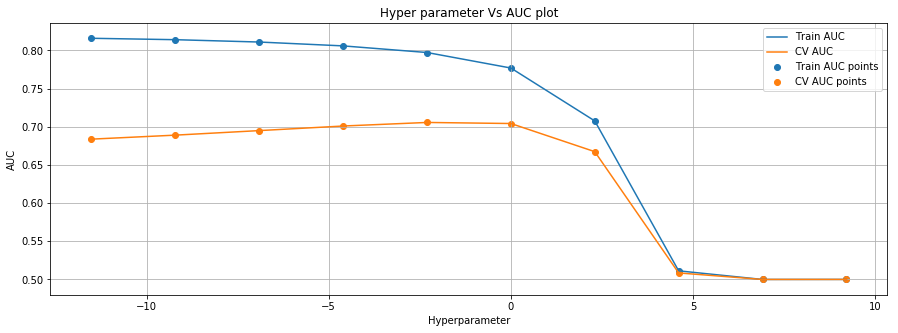

In [34]:
# Ref link : https://stackoverflow.com/questions/51194627/python-naive-bayes-with-cross-validation-using-gaussiannb-classifier
import math

param_grid = {'alpha': (10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001)}
nb = MultinomialNB(class_prior = [0.5, 0.5])
gs_bow = GridSearchCV(nb, param_grid, cv = 10, return_train_score = True, scoring = 'roc_auc')
gs_bow.fit(X_tr_bow, y_train)

results = pd.DataFrame.from_dict(gs_bow.cv_results_)
results = results.sort_values(["param_alpha"])

train_auc = results['mean_train_score']
train_auc_std = results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std = results['std_test_score']
alphas = results["param_alpha"]
log_alphas = []

for i in alphas:
    a = math.log(i)
    log_alphas.append(a)

plt.figure(figsize=(15, 5))
plt.plot(log_alphas, train_auc, label = 'Train AUC')
plt.plot(log_alphas, cv_auc, label = 'CV AUC')

plt.scatter(log_alphas, train_auc, label = 'Train AUC points')
plt.scatter(log_alphas, cv_auc, label = 'CV AUC points')

plt.legend()
plt.grid()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")

plt.show()

In [35]:
print('Best score: ', gs_bow.best_score_)
print('alpha value with best score: ', gs_bow.best_params_)

Best score:  0.7056538048857156
alpha value with best score:  {'alpha': 0.1}


In [36]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

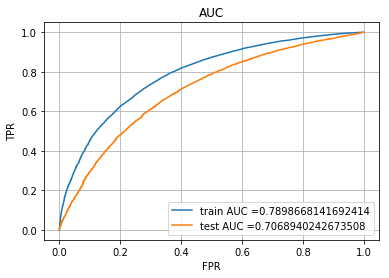

In [37]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

nb_bow = MultinomialNB(alpha = gs_bow.best_params_["alpha"], class_prior = [0.5, 0.5])
nb_bow.fit(X_tr_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(nb_bow, X_tr_bow)    
y_test_pred = batch_predict(nb_bow, X_te_bow)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label = "train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC")
plt.grid()

plt.show()

In [38]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr

def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("The maximum value of tpr*(1-fpr) is", max(tpr*(1-fpr)), "for threshold", np.round(t, 3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i >= threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [39]:
from sklearn.metrics import confusion_matrix

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

print("=" * 100)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("=" * 100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

The maximum value of tpr*(1-fpr) is 0.5166396360732859 for threshold 0.531
Train confusion matrix
[[ 8016  3067]
 [17745 44368]]
Test confusion matrix
[[ 3375  2084]
 [ 9363 21230]]


## 2.3 Set-2 : TFIDF

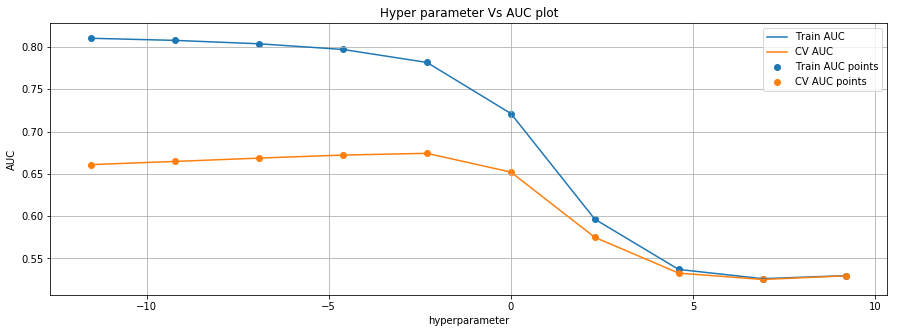

In [40]:
# Ref link : https://stackoverflow.com/questions/51194627/python-naive-bayes-with-cross-validation-using-gaussiannb-classifier

param_grid = {'alpha': (10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001)}
nb = MultinomialNB(class_prior = [0.5, 0.5])
gs_tfidf = GridSearchCV(nb, param_grid, cv = 10, return_train_score = True, scoring = 'roc_auc')
gs_tfidf.fit(X_tr_tfidf, y_train)

results = pd.DataFrame.from_dict(gs_tfidf.cv_results_)
results = results.sort_values(["param_alpha"])

train_auc = results['mean_train_score']
train_auc_std = results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std = results['std_test_score']
alphas = results["param_alpha"]
log_alphas = []

for i in alphas:
    a = math.log(i)
    log_alphas.append(a)

plt.figure(figsize=(15, 5))
plt.plot(log_alphas, train_auc, label = 'Train AUC')
plt.plot(log_alphas, cv_auc, label = 'CV AUC')

plt.scatter(log_alphas, train_auc, label ='Train AUC points')
plt.scatter(log_alphas, cv_auc, label ='CV AUC points')

plt.legend()
plt.grid()
plt.xlabel("hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")

plt.show()

In [41]:
print('Best score: ', gs_tfidf.best_score_)
print('alpha value with best score: ', gs_tfidf.best_params_)

Best score:  0.674207259586825
alpha value with best score:  {'alpha': 0.1}


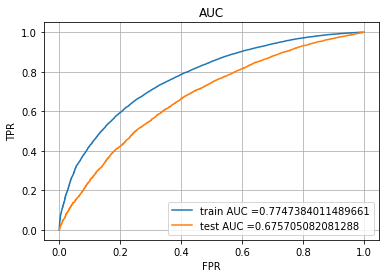

In [42]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve

nb_tfidf = MultinomialNB(alpha = gs_tfidf.best_params_["alpha"], class_prior = [0.5, 0.5])
nb_tfidf.fit(X_tr_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred_tfidf = batch_predict(nb_tfidf, X_tr_tfidf)    
y_test_pred_tfidf = batch_predict(nb_tfidf, X_te_tfidf)

train_fpr, train_tpr, tr_thresholds_tfidf = roc_curve(y_train, y_train_pred_tfidf)
test_fpr, test_tpr, te_thresholds_tfidf = roc_curve(y_test, y_test_pred_tfidf)

plt.plot(train_fpr, train_tpr, label = "train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC")
plt.grid()

plt.show()

In [43]:
best_t = find_best_threshold(tr_thresholds_tfidf, train_fpr, train_tpr)

print("=" * 100)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_tfidf, best_t)))
print("=" * 100)
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_tfidf, best_t)))

The maximum value of tpr*(1-fpr) is 0.4947740078859192 for threshold 0.502
Train confusion matrix
[[ 7875  3208]
 [18862 43251]]
Test confusion matrix
[[ 3203  2256]
 [ 9905 20688]]


In [44]:
# Ref link : https://datascience.stackexchange.com/questions/65219/find-the-top-n-features-from-feature-set-using-absolute-values-of-feature-log-p

# Negative Class
neg_class = nb_bow.feature_log_prob_[0, :].argsort()

# Positive Class
pos_class = nb_bow.feature_log_prob_[1, :].argsort()

In [45]:
feature_lst = list(vectorizer_title_bow.get_feature_names() + vectorizer_essay_bow.get_feature_names() + 
                   vectorizer_state.get_feature_names() + vectorizer_prefix.get_feature_names() + 
                   vectorizer_grade.get_feature_names() + vectorizer_cat.get_feature_names() + 
                   vectorizer_subcat.get_feature_names() + ["teacher_number_of_previously_posted_projects"] + ['price'])

In [46]:
most_imp_neg_words = []
most_imp_pos_words = []

for i in neg_class[-20 : ]:
    most_imp_neg_words.append(feature_lst[i])
    
for i in pos_class[-20 : ]:
    most_imp_pos_words.append(feature_lst[i])

print("Top 10 features from negative class :\n")
print(most_imp_neg_words)
print("=" * 100)
print("Top 10 features from positive class :\n")
print(most_imp_pos_words)

Top 10 features from negative class :

['class', 'day', 'use', 'able', 'skills', 'materials', 'reading', 'love', 'come', 'work', 'need', 'many', 'nannan', 'help', 'learn', 'not', 'classroom', 'learning', 'school', 'students']
Top 10 features from positive class :

['technology', 'would', 'class', 'come', 'able', 'day', 'love', 'use', 'reading', 'work', 'need', 'nannan', 'many', 'help', 'learn', 'not', 'classroom', 'learning', 'school', 'students']


# 3. Summary

In [48]:
# Ref link : http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyper Parameter", "AUC"]

x.add_row(["BOW", "Naive Bayes", 0.1, 0.705])
x.add_row(["TFIDF", "Naive Bayes", 0.1, 0.674])

print(x)

+------------+-------------+-----------------+-------+
| Vectorizer |    Model    | Hyper Parameter |  AUC  |
+------------+-------------+-----------------+-------+
|    BOW     | Naive Bayes |       0.1       | 0.705 |
|   TFIDF    | Naive Bayes |       0.1       | 0.674 |
+------------+-------------+-----------------+-------+
